In [33]:
%matplotlib widget

In [10]:
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
import numpy as np
from ephysvibe.task import task_constants,def_task
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd

In [11]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [12]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

In [13]:
# def compute_neuron_avr(data,bhv):
#     t_before = 200
#     t_after = 850
#     in_out='in'
#     cgroup='good'
#     e_align="sample_on"
#     # select correct trials in block 1 (DMT)
#     trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
#     # check the in out correction
#     if np.any(np.isnan(data.neuron_cond)):
#         neuron_cond = np.ones(len(data.clustersgroup))
#     else:
#         neuron_cond=data.neuron_cond
#     # define task frame
#     task = def_task.create_task_frame(
#         condition=bhv.condition[trials_b1],
#         test_stimuli=bhv.test_stimuli[trials_b1],
#         samples_cond=task_constants.SAMPLES_COND,
#         neuron_cond = neuron_cond,
#     )
#     # select cluster group
#     if cgroup == 'all':
#         neurons = np.where(data.clustersgroup != cgroup)[0]
#     else:
#         neurons = np.where(data.clustersgroup == cgroup)[0]
#     if neurons.shape[0] == 0:
#         return np.nan
#     # select trials with the condition in_out
#     task = task[np.logical_and(np.in1d(task['i_neuron'].values,neurons),task['in_out']==in_out)]
#     # split in two groups where the neurons in each have the same trials in in or out
#     task_1 = task[task['i_neuron']==neurons[0]].copy()
#     trials_neuron = task_1['trial_idx'].values
#     task_1['trial_idx'] = task_1['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))
#     t_neurons = task[np.in1d(task['trial_idx'].values,trials_neuron)]['i_neuron'].unique()
#     t_neurons_2=neurons[~np.in1d(neurons,t_neurons)]
#     task_all = [task_1]
#     if len(t_neurons_2) != 0:
#         trials_neuron_2 = task[task['i_neuron']==t_neurons_2[0]]['trial_idx'].values
#         trials_neuron = [trials_neuron,trials_neuron_2]
#         t_neurons = [t_neurons,t_neurons_2]
#         task_2 = task[task['i_neuron']==t_neurons_2[0]].copy()
#         task_2['trial_idx'] = task_2['trial_idx'].replace(trials_neuron_2,np.arange(0,len(trials_neuron_2)))
#         task_all = [task_1,task_2]
#     else:
#         trials_neuron = [trials_neuron]
#         t_neurons = [t_neurons]

#     sp_avg_all = []
#     for i_task, (trial_idx_n, neurons,task) in enumerate(zip(trials_neuron,t_neurons,task_all)):

#         trials_s_on = data.code_samples[
#             trials_b1[trial_idx_n],
#             np.where(data.code_numbers[trials_b1[trial_idx_n]] == task_constants.EVENTS_B1[e_align])[
#                 1
#             ],
#         ]
#         shifts = -(trials_s_on - t_before).astype(int)
#         shifts = shifts[:,np.newaxis]
#         shift_sp = SpikeData.indep_roll(data.sp_samples[trials_b1[trial_idx_n]][:,neurons], shifts, axis=2)[:,:, :t_before+t_after]
#         #sp_avg = moving_average(shift_sp, win=win, step=step)
#         #sp_avg = np.mean(shift_sp,axis=0)
#         sp_avg_all.append(shift_sp)
#     # average activity of each neuron for each sample 
#     sp_avg = []
#     for i_samp in ['o1_c1', 'o1_c5', 'o5_c1', 'o5_c5']:#, 'o0_c0'
#         i_t=task_all[0][task_all[0]['sample']==i_samp]['trial_idx'].values
#         sp_avg.append(np.mean(sp_avg_all[0][i_t],axis=0))
#     sp_avg=np.concatenate(sp_avg,axis=1)

#     return sp_avg

In [14]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
        for i_step in np.arange(0,d_shape[1]-win,step):
            d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1
    return d_avg

In [63]:
def compute_neuron_avr(data,bhv,rf_all_b1,date):
    t_before = 250
    t_after = 600
    win=100
    in_out='in'
    cgroup='all'
    e_align="sample_on"
    # select correct trials in block 1 (DMTS)
    trials_b2 = np.where(np.logical_and(data.trial_error == 0, data.block == 2))[0]
    code_samples=data.code_samples[trials_b2]
    sp_samples=data.sp_samples[trials_b2]
    # check the in out correction
    # Define target codes 
    position_codes= {
        # code: [[MonkeyLogic axis], [plot axis]]
        '127': [[10,0],[1,2],[0]],
        '126': [[7,7],[0,2],[45]],
        '125': [[0,10],[0,1],[90]],
        '124': [[-7,7],[0,0],[135]],
        '123': [[-10,0],[1,0],[180]],
        '122': [[-7,-7],[2,0],[225]],
        '121': [[0,-10],[2,1],[270]],
        '120': [[7,-7],[2,2],[315]],
    }
    # create dict with the trials having each code
    target_codes = {}
    for key in position_codes.keys():
        trials = []
        code_idx=[]
        for i_trial,code in enumerate(data.code_numbers[trials_b2]):
            idx=np.where(int(key) == code)[0]
            if len(idx)!=0:
                code_idx.append(idx[0])
                trials.append(i_trial)
        target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1],'angle_codes':position_codes[key][2][0]}
    # select cluster group
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]
    print(date)
    if neurons.shape[0] == 0:
        print(len(neurons))
        return np.nan
    print(len(neurons))
    rf_neurons = rf_all_b1[['date','array_position']][rf_all_b1['date']==date]
    neurons = neurons[np.in1d(neurons,rf_neurons['array_position'].values)]
    if len(neurons) == 0:
        print(0)
        return np.nan
    print(len(neurons))

    shifts = code_samples[:, 3]
    
    shifts = shifts[:, np.newaxis]
    shift_sp = SpikeData.indep_roll(sp_samples, -(shifts - t_before).astype(int), axis=2)[
        :, :, : t_after + t_before+win
    ]    

    # average activity of each neuron for each sample
    sp_avg = []
    for i_k in target_codes.keys():#, 'o0_c0'
        i_t=target_codes[i_k]['trial_idx']
        sp_trials = np.mean(shift_sp[i_t],axis=0)
        sp_time_avg = moving_average(data=sp_trials,win=win,step=1)[:, 50:t_before+t_after]
        sp_avg.append(sp_time_avg)
    sp_avg=np.concatenate(sp_avg,axis=1)
    #sp_avg=sp_avg - sp_avg.mean(axis=1)[:, np.newaxis]
    return sp_avg

In [64]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_decoding.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_decoding.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

In [65]:
directory_b1="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/detect_rf/lip/b2"
rf_path_b1 = os.path.normpath(str(directory_b1) + "/*.csv")
rf_path_b1 = glob.glob(rf_path_b1, recursive=True)
rf_all = []
for n_path in rf_path_b1:
    rf = pd.read_csv(n_path)
    rf_all.append(rf)
rf_all_b1 = pd.concat(rf_all).reset_index(drop=True)

In [66]:
rf_b1 = rf_all_b1#[rf_all_b1['vm_index'] <0]#rf_all_b1#
rf_b1.shape

(470, 23)

In [67]:
paths_sp[0]

'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2022-11-22_10-59-03_Riesling_lip_e1_r1_sp.h5'

In [68]:
sp_avg_all=[]
for n_bhv,n_sp in zip(paths_bhv,paths_sp):
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    s_path = os.path.normpath(n_sp).split(os.sep)
    date = s_path[-1][:19]
    neus_avg = compute_neuron_avr(data,bhv,rf_b1,date)
    if np.any(np.isnan(neus_avg)):
        print(n_bhv)
        continue
    
    sp_avg_all.append(neus_avg)
sp_avg = np.concatenate(sp_avg_all,axis=0)

2022-11-22_10-59-03
5
5
2022-11-28_10-23-27
4
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-11-28_10-23-27_Riesling_e1_r1_bhv.h5
2022-11-30_10-42-03
8
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-11-30_10-42-03_Riesling_e1_r1_bhv.h5
2022-12-01_10-23-18
5
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-01_10-23-18_Riesling_e1_r1_bhv.h5
2022-12-01_12-01-59
8
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-01_12-01-59_Riesling_e1_r1_bhv.h5
2022-12-02_11-01-23
18
18


/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-02_11-01-23_Riesling_e1_r1_bhv.h5
2022-12-05_10-51-52
19
19
2022-12-06_11-12-04
9
9
2022-12-13_11-11-42
6
6
2022-12-14_10-50-49
13
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-14_10-50-49_Riesling_e1_r1_bhv.h5
2022-12-16_10-30-59
16
16
2023-01-18_10-22-38
7
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-01-18_10-22-38_Riesling_e1_r1_bhv.h5
2023-01-20_11-00-24
20
20
2023-01-23_10-10-27
10
10
2023-01-26_10-45-42
11
11
2023-02-08_10-39-41
8
8
2023-02-09_10-42-54
4
4
2023-02-24_10-43-44
2
2
2023-02-27_10-50-03
9
9
2023-02-28_10-15-02
9
0
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-02-28_10-15-02_Riesling_e1_r1_bhv.h5
2023-03-01_10-18-38
22
22
2023-03-03_10-59-32
1
1
2023-03-06_10-32-51
11
11
2023-03-07_10-14-11
8
8
2023-03-09_10-35-09
3
3
2023-03-10_10-30-26
8
8
2023-03-14_10-33-51
3
3
2

In [69]:
sp_avg.shape[1]/8

800.0

In [70]:
# sp_avg_all=[]
# n_sp='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-10-10_10-41-43_Riesling_lip_e1_r1_sp.h5'
# data = SpikeData.from_python_hdf5(n_sp)
# n_bhv='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-10_10-41-43_Riesling_e1_r1_bhv.h5'
# bhv = BhvData.from_python_hdf5(n_bhv)
# print(n_bhv)
# sp_avg_all.append(compute_neuron_avr(data,bhv))

In [71]:
sp_avg_lip = sp_avg
sp_avg_v4 = sp_avg
sp_avg_pfc = sp_avg
sp_avg_v4_vd0 = sp_avg

In [72]:
#np.save('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_v4_good_vdidxinf0.npy',sp_avg)

In [73]:
# sp_avg_pfc = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_pfc_good.npy')
# sp_avg_v4 = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_v4_good.npy')
# #sp_avg_lip = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_lip_good.npy')
# sp_avg_v4_vd0 = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_v4_good_vdidxinf0.npy')

In [74]:
print(sp_avg_pfc.shape,sp_avg_v4.shape,sp_avg_lip.shape,sp_avg_v4_vd0.shape)

(217, 6400) (217, 6400) (217, 6400) (217, 6400)


In [75]:
4200/4

1050.0

In [76]:
def compute_pca(sp_avg,n_comp):
    # perform PCA
    #sp_avg = sp_avg[:,2200:]
    sp_avg_z = z_score(sp_avg)
    model = PCA(n_components=n_comp).fit(sp_avg_z.T)
    C = model.components_
    pc_s = C @ sp_avg_z
    model
    #print(pc_s.shape)
    return model,pc_s

In [77]:
def plot_pcs(mean_co_pcs,n_pcs,area,ax):
    fix_idx = np.arange(0,200,1)
    samp1_idx = np.arange(200,250,1)
    delay_idx = np.arange(250,850,1)
    
    
    for i in np.arange(0,1):
        
        
        ax.plot(mean_co_pcs[i][fix_idx],mean_co_pcs[i+1][fix_idx],label='fixation')
        ax.plot(mean_co_pcs[i][samp1_idx],mean_co_pcs[i+1][samp1_idx],label='sample')
       
        ax.plot(mean_co_pcs[i][delay_idx],mean_co_pcs[i+1][delay_idx],label='delay')

        ax.set(xlabel="PC "+str(i), ylabel="PC "+str(i+1),title=area)
        

In [78]:

# perform PCA
#sp_avg = sp_avg[:,2200:]
sp_avg_pfc_z = z_score(sp_avg_pfc)
sp_avg_lip_z = z_score(sp_avg_lip)
sp_avg_v4_z = z_score(sp_avg_v4_vd0)
sp_avg_z =np.concatenate([sp_avg_pfc_z,sp_avg_lip_z,sp_avg_v4_z],axis=0)
model = PCA(n_components=10).fit(sp_avg_z.T)
C = model.components_
pc_s = C @ sp_avg_z
reshape_pc_s = pc_s.reshape(10,-1,1000)
mean_co_pcs = np.mean(reshape_pc_s,axis=1)

fix_idx = np.arange(0,100,1)
fix2_idx = np.arange(100,200,1)
samp1_idx = np.arange(200,400,1)
samp2_idx = np.arange(400,650,1)
delay_idx = np.arange(650,1000,1)
fig,ax = plt.subplots(figsize=(6,6))#, subplot_kw={'projection': '3d'}
i=0
ax.plot(mean_co_pcs[i][fix_idx],mean_co_pcs[i+1][fix_idx],label='fixation')
ax.plot(mean_co_pcs[i][fix2_idx],mean_co_pcs[i+1][fix2_idx],label='fixation2')
ax.plot(mean_co_pcs[i][samp1_idx],mean_co_pcs[i+1][samp1_idx],label='sample first part')
ax.plot(mean_co_pcs[i][samp2_idx],mean_co_pcs[i+1][samp2_idx],label='sample 2nd part')
ax.plot(mean_co_pcs[i][delay_idx],mean_co_pcs[i+1][delay_idx],label='delay')
np.cumsum(model.explained_variance_ratio_)[:4]

ValueError: cannot reshape array of size 64000 into shape (10,newaxis,1000)

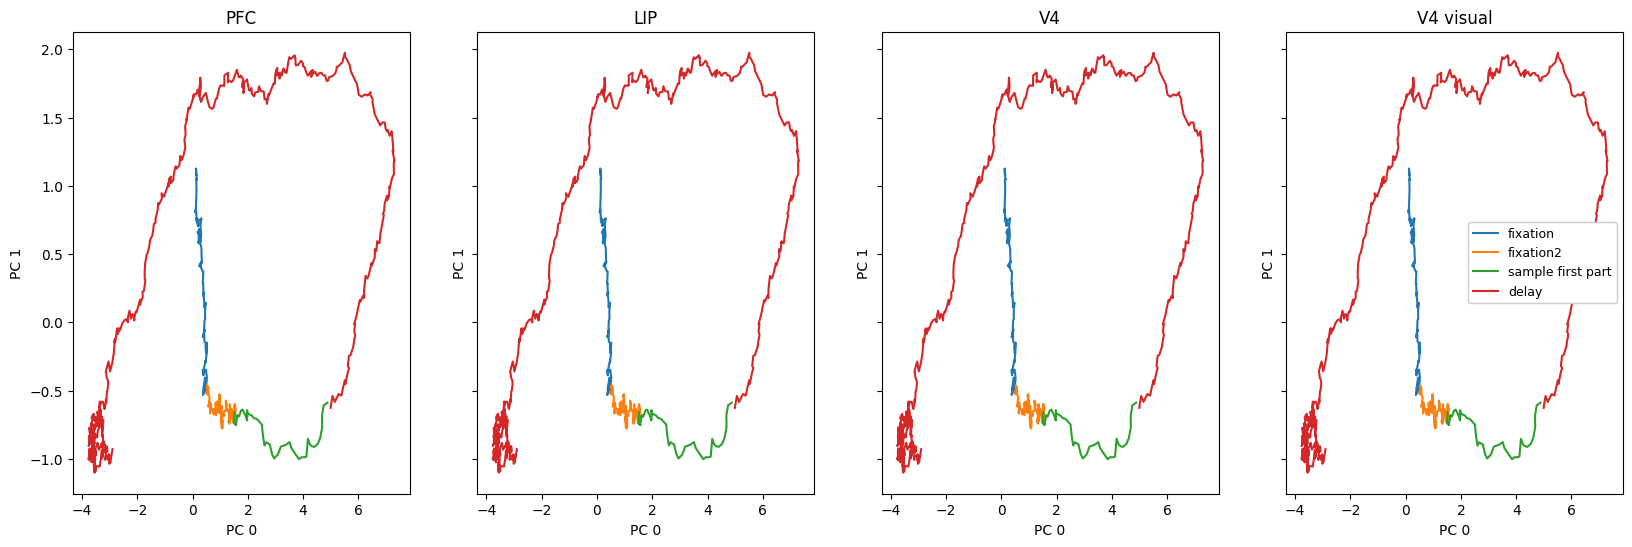

In [ ]:
n_comp = 69
all_model = []
fig,ax = plt.subplots(1,4,figsize=(20,6),sharex=True,sharey=True)#, subplot_kw={'projection': '3d'}
for i,(sp_avg,area) in enumerate(zip([sp_avg_pfc,sp_avg_lip,sp_avg_v4,sp_avg_v4_vd0],['PFC','LIP','V4','V4 visual'])):
    model,pc_s = compute_pca(sp_avg,n_comp)
    all_model.append(model)
    reshape_pc_s = pc_s.reshape(n_comp,-1,850)
    co_pcs = reshape_pc_s#[:,:,:]
    n_pcs = reshape_pc_s[:,0,:]
    mean_co_pcs = np.mean(co_pcs,axis=1)
    
    plot_pcs(mean_co_pcs,n_pcs,area,ax[i])
ax[i].legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1)

In [ ]:
np.cumsum(all_model[1].explained_variance_ratio_)[:4]

array([0.2906642 , 0.47500299, 0.60372536, 0.65389042])

In [ ]:
np.cumsum(all_model[1].explained_variance_ratio_)[:4]

array([0.30206898, 0.49637659, 0.63580713, 0.69968348])

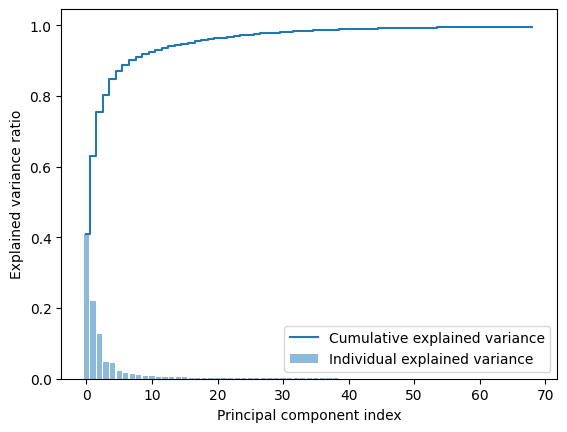

In [ ]:
fig,ax = plt.subplots()
exp_var_pca = all_model[0].explained_variance_ratio_
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [111]:
def plot3d_pcs(mean_co_pcs,n_pcs,area):
    fix_idx = np.arange(0,100,2)
    fix2_idx = np.arange(100,200,2)
    samp1_idx = np.arange(200,400,2)
    samp2_idx = np.arange(400,650,2)
    delay_idx = np.arange(650,1000,2)

    for i in np.arange(0,1,2):
        fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True,sharex=True, subplot_kw={'projection': '3d'})#
        
        ax[0].plot(mean_co_pcs[i][fix_idx],mean_co_pcs[i+1][fix_idx],mean_co_pcs[i+2][fix_idx],label='fixation')
        ax[0].plot(mean_co_pcs[i][fix2_idx],mean_co_pcs[i+1][fix2_idx],mean_co_pcs[i+2][fix2_idx],label='fixation2')
        ax[0].plot(mean_co_pcs[i][samp1_idx],mean_co_pcs[i+1][samp1_idx],mean_co_pcs[i+2][samp1_idx],label='sample first part')
        ax[0].plot(mean_co_pcs[i][samp2_idx],mean_co_pcs[i+1][samp2_idx],mean_co_pcs[i+2][samp2_idx],label='sample 2nd part')
        ax[0].plot(mean_co_pcs[i][delay_idx],mean_co_pcs[i+1][delay_idx],mean_co_pcs[i+2][delay_idx],label='delay')
        
        ax[1].plot(n_pcs[i][fix_idx],n_pcs[i+1][fix_idx],n_pcs[i+2][fix_idx],label='fixation')
        ax[1].plot(n_pcs[i][fix2_idx],n_pcs[i+1][fix2_idx],n_pcs[i+2][fix2_idx],label='fixation2')
        ax[1].plot(n_pcs[i][samp1_idx],n_pcs[i+1][samp1_idx],n_pcs[i+2][samp1_idx],label='sample first ms')
        ax[1].plot(n_pcs[i][samp2_idx],n_pcs[i+1][samp2_idx],n_pcs[i+2][samp2_idx],label='sample 2nd ms')
        ax[1].plot(n_pcs[i][delay_idx],n_pcs[i+1][delay_idx],n_pcs[i+2][delay_idx],label='delay')

        fig.suptitle(area)
        ax[0].set(xlabel="PC "+str(i), ylabel="PC "+str(i+1))
        ax[1].set(xlabel="PC "+str(i), ylabel="PC "+str(i+1))
        ax[1].legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')

In [112]:
all_model = []
for sp_avg,area in zip([sp_avg_pfc,sp_avg_v4,sp_avg_lip],['PFC','V4','LIP']):#
    model,pc_s = compute_pca(sp_avg,n_comp)
    all_model.append(model)
    reshape_pc_s = pc_s.reshape(144,-1,1050)
    co_pcs = reshape_pc_s[:,:4,:]
    n_pcs = reshape_pc_s[:,-1,:]
    mean_co_pcs = np.mean(co_pcs,axis=1)
    plot3d_pcs(mean_co_pcs,n_pcs,area)

ValueError: cannot reshape array of size 280000 into shape (144,newaxis,1050)